In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats as sts
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
print("Success import")

Success import


In [35]:
start_date = "2015-01-01"
end_date   = None  # today

gold_data   = yf.download("GC=F", start_date, end_date, progress=False)
goldprice   = gold_data['Close']
print(f" Gold data: {len(goldprice)} days")

silver_data = yf.download("SI=F", start=start_date, end=end_date, progress=False)
silverprice = silver_data['Close']
print(f" Silver data: {len(silverprice)} days")

data = pd.concat([goldprice, silverprice], axis=1)
data.columns = ['Gold', 'Silver']
data = data.dropna()

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"\nFirst few rows:")
print(data.head())

 Gold data: 2800 days
 Silver data: 2800 days

Data shape: (2800, 2)
Date range: 2015-01-02 to 2026-02-23

First few rows:
                   Gold     Silver
Date                              
2015-01-02  1186.000000  15.734000
2015-01-05  1203.900024  16.179001
2015-01-06  1219.300049  16.603001
2015-01-07  1210.599976  16.510000
2015-01-08  1208.400024  16.351000


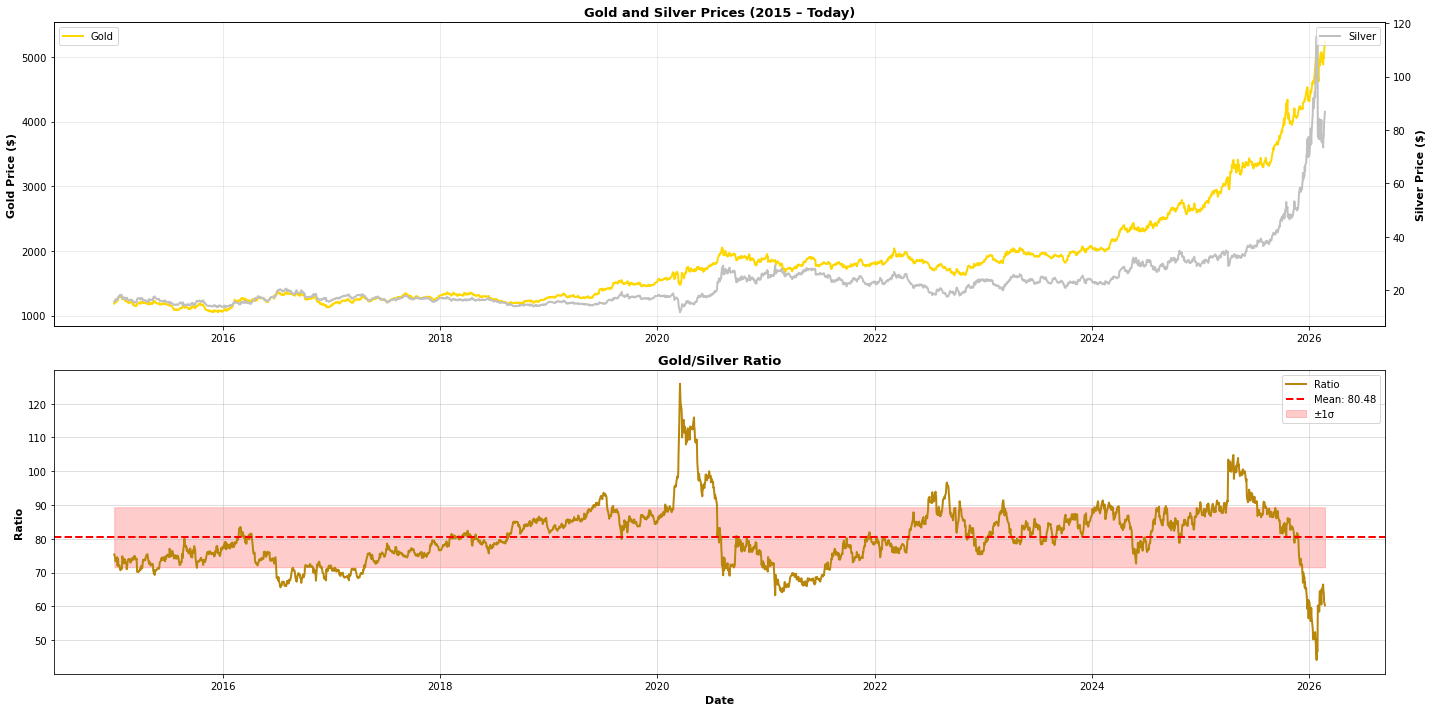

In [36]:
fig, (f1, f2) = plt.subplots(2, 1, figsize=(20, 10))

x   = data.index.to_numpy()
gold = data["Gold"].to_numpy()
slv  = data["Silver"].to_numpy()

f1.plot(x, gold, label="Gold", linewidth=2, color='gold')
f1.set_ylabel('Gold Price ($)', fontsize=11, fontweight='bold')
f1.set_title('Gold and Silver Prices (2015 – Today)', fontsize=13, fontweight='bold')
f1.legend()
f1.grid(True, alpha=0.3)

f1_twin = f1.twinx()
f1_twin.plot(x, slv, label='Silver', linewidth=2, color='silver')
f1_twin.set_ylabel('Silver Price ($)', fontsize=11, fontweight='bold')
f1_twin.legend(loc='upper right')

ratio = gold / slv
mean  = ratio.mean()
std   = ratio.std()

f2.plot(x, ratio, linewidth=2, color='darkgoldenrod', label='Ratio')
f2.axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
f2.fill_between(x, mean - std, mean + std, alpha=0.2, color='red', label='±1σ')
f2.set_ylabel('Ratio', fontsize=11, fontweight='bold')
f2.set_xlabel('Date',  fontsize=11, fontweight='bold')
f2.set_title('Gold/Silver Ratio', fontsize=13, fontweight='bold')
f2.legend()
f2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [37]:
# ============================================================
# SPLIT: Train | Test | Validate
# ============================================================
train_end = '2019-12-31'
test_end  = '2021-12-31'
# validate  = 2024-01-01 → today

data_train = data[data.index <= train_end]
data_test  = data[(data.index > train_end) & (data.index <= test_end)]
data_val   = data[data.index > test_end]

print(f"TRAIN    : {data_train.index.min().date()} → {data_train.index.max().date()}  ({len(data_train)} days)")
print(f"TEST     : {data_test.index.min().date()}  → {data_test.index.max().date()}   ({len(data_test)} days)")
print(f"VALIDATE : {data_val.index.min().date()}   → {data_val.index.max().date()}    ({len(data_val)} days)")

TRAIN    : 2015-01-02 → 2019-12-31  (1255 days)
TEST     : 2020-01-02  → 2021-12-31   (505 days)
VALIDATE : 2022-01-03   → 2026-02-23    (1040 days)


In [51]:
# ============================================================
# COINTEGRATION & STATIONARITY — TRAIN PERIOD ONLY
# ============================================================
gold_norm   = (data_train['Gold']   - data_train['Gold'].mean())   / data_train['Gold'].std()
silver_norm = (data_train['Silver'] - data_train['Silver'].mean()) / data_train['Silver'].std()

print("=" * 60)
print("COINTEGRATION AND STATIONARITY TESTS  [TRAIN 2015-2022]")
print("=" * 60)

print("\n 1.  Gold ADF Test")
print('-' * 60)
result_gold = adfuller(gold_norm, autolag='AIC')
print(f" Test Statistics: {result_gold[0]: .6f}")
print(f" p_value:         {result_gold[1]: .6f}")
print(f"  {'Stationary' if result_gold[1] < 0.10 else 'Non-stationary (expected - prices have trends)'}")

print("\n 2.  Silver ADF Test")
print('-' * 60)
result_slv = adfuller(silver_norm, autolag='AIC')
print(f" Test Statistics: {result_slv[0]: .6f}")
print(f" p_value:         {result_slv[1]: .6f}")
print(f"  {'Stationary' if result_slv[1] < 0.10 else 'Non-stationary (expected - prices have trends)'}")

print("\n 3.  Regression Relationship")
print('-' * 60)
slope, intercept, r_value, p_val, std_err = sts.linregress(gold_norm, silver_norm)
print(f" Silver = {intercept:.4f} + {slope:.4f} × Gold")
print(f" R²     = {r_value**2: .4f}")
print(" Long term equilibrium relationship")

ols_spread = silver_norm - intercept - slope * gold_norm

print("\n 4.  ADF on OLS Spread")
print('-' * 60)
res_spread = adfuller(ols_spread, autolag='AIC')
print(f" Test Statistics: {res_spread[0]: .6f}")
print(f" p_value:         {res_spread[1]: .6f}")
if res_spread[1] < 0.10:
    print("  Spread IS STATIONARY — Mean reversion will work!")
else:
    print("  Spread is NOT stationary — Mean reversion may not work")


COINTEGRATION AND STATIONARITY TESTS  [TRAIN 2015-2022]

 1.  Gold ADF Test
------------------------------------------------------------
 Test Statistics: -0.866236
 p_value:          0.798888
  Non-stationary (expected - prices have trends)

 2.  Silver ADF Test
------------------------------------------------------------
 Test Statistics: -2.915659
 p_value:          0.043557
  Stationary

 3.  Regression Relationship
------------------------------------------------------------
 Silver = -0.0000 + 0.5286 × Gold
 R²     =  0.2794
 Long term equilibrium relationship

 4.  ADF on OLS Spread
------------------------------------------------------------
 Test Statistics: -2.720742
 p_value:          0.070517
  Spread IS STATIONARY — Mean reversion will work!


In [39]:
class KalmanFilter:
    def __init__(self, goldp, silverp, ref_gold, ref_silver,
                 process_var=1e-5, measurement_var=0.01,
                 init_beta=None, init_alpha=None, init_p=0.1):

        self.gold       = np.array(goldp,   dtype=float)
        self.silver     = np.array(silverp, dtype=float)
        self.ref_gold   = ref_gold
        self.ref_silver = ref_silver
        self.Q          = process_var
        self.R          = measurement_var
        self.init_beta  = init_beta
        self.init_alpha = init_alpha
        self.init_p     = init_p

    def filter(self):
        if self.init_beta is None or self.init_alpha is None:
            beta, alpha, *_ = sts.linregress(self.gold[:100], self.silver[:100])
        else:
            beta, alpha = self.init_beta, self.init_alpha

        p      = self.init_p
        betas  = []
        alphas = []

        for t in range(len(self.gold)):
            x_t = self.gold[t]
            y_t = self.silver[t]

            y_pred     = alpha + beta * x_t
            innovation = y_t - y_pred

            s = p + self.R
            k = p / s

            beta = beta + k * innovation * x_t / (1 + x_t**2)
            if abs(beta) > 100:
                beta = np.sign(beta) * 100

            p     = (1 - k) * p + self.Q
            alpha = alpha + 0.001 * innovation

            betanormal = beta  * self.ref_silver.std() / self.ref_gold.std()
            alphanorm  = (self.ref_silver.mean() + self.ref_silver.std() * alpha
                          - betanormal * self.ref_gold.mean())
            betas.append(betanormal)
            alphas.append(alphanorm)

        return np.array(betas), np.array(alphas), beta, alpha, p


print("Running Kalman Filter on TRAIN...")
kf_train = KalmanFilter(gold_norm, silver_norm,
                         ref_gold=data_train['Gold'], ref_silver=data_train['Silver'])
betas_train, alphas_train, last_beta, last_alpha, last_p = kf_train.filter()

print(f"✓ Kalman filter complete!")
print(f"\nDynamic Hedge Ratio β(t) Statistics [TRAIN]:")
print(f"  Mean : {betas_train.mean():.6f}")
print(f"  Std  : {betas_train.std():.6f}")
print(f"  Min  : {betas_train.min():.6f}")
print(f"  Max  : {betas_train.max():.6f}")

Running Kalman Filter on TRAIN...
✓ Kalman filter complete!

Dynamic Hedge Ratio β(t) Statistics [TRAIN]:
  Mean : 0.014798
  Std  : 0.008336
  Min  : -0.002201
  Max  : 0.027036


In [40]:
# ============================================================
# KALMAN SPREAD STATIONARITY CHECK — TRAIN
# ============================================================
kalman_spread_train = pd.Series(
    data_train['Silver'].values - alphas_train - betas_train * data_train['Gold'].values,
    index=data_train.index)

print("=" * 60)
print("ADF TEST ON KALMAN SPREAD  [TRAIN 2015-2022]")
print("=" * 60)
res_ks_train = adfuller(kalman_spread_train.dropna(), autolag='AIC')
print(f" Test Statistics : {res_ks_train[0]:.6f}")
print(f" p-value         : {res_ks_train[1]:.6f}")
print(f" Lags used       : {res_ks_train[2]}")
print()
print(" Critical Values:")
for level, cv in res_ks_train[4].items():
    marker = '  ✓' if res_ks_train[0] < cv else '  ✗'
    print(f"   {level}: {cv:.4f}{marker}")
print()
if res_ks_train[1] < 0.10:
    print(" RESULT: Kalman spread IS STATIONARY ✓")
    print("  The spread we trade is mean-reverting on train!")
else:
    print(" RESULT: Kalman spread is NOT stationary ✗")
    print("  Mean reversion on train may not be reliable")
print("=" * 60)

ADF TEST ON KALMAN SPREAD  [TRAIN 2015-2022]
 Test Statistics : -2.624033
 p-value         : 0.088131
 Lags used       : 1

 Critical Values:
   1%: -3.4356  ✗
   5%: -2.8638  ✗
   10%: -2.5680  ✓

 RESULT: Kalman spread IS STATIONARY ✓
  The spread we trade is mean-reverting on train!


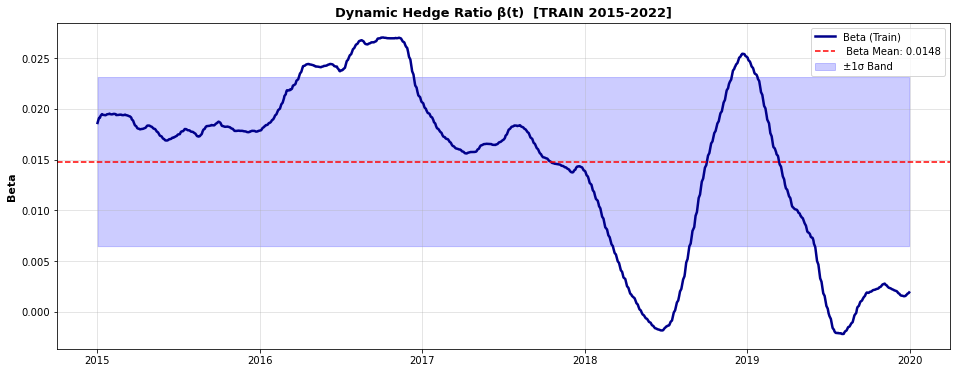

In [41]:
fig, a = plt.subplots(figsize=(16, 6))

x_train = data_train.index.to_numpy()

a.plot(x_train, betas_train, color='darkblue', linewidth=2.5, label='Beta (Train)')
a.axhline(betas_train.mean(), color='red', linestyle='--',
          label=f' Beta Mean: {betas_train.mean():.4f}')
a.fill_between(x_train,
               betas_train.mean() - betas_train.std(),
               betas_train.mean() + betas_train.std(),
               color='blue', alpha=0.2, label='±1σ Band')
a.set_title('Dynamic Hedge Ratio β(t)  [TRAIN 2015-2022]', fontsize=13, fontweight='bold')
a.set_ylabel('Beta', fontsize=11, fontweight='bold')
a.legend()
a.grid(True, alpha=0.4)
plt.show()

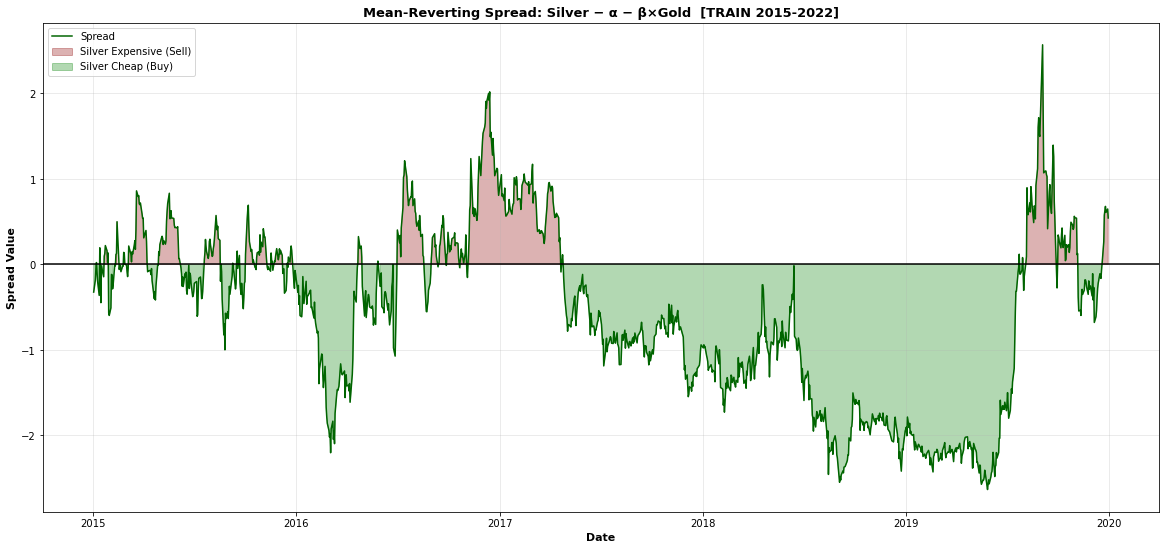

Z-Score Statistics [TRAIN]:
  Mean : -0.035989 (should be ≈ 0)
  Std  : 1.257168  (should be ≈ 1)
  Min  : -3.61
  Max  : 3.36

Signal Occurrences [TRAIN]:
  Long signals  (Z < -1σ) : 304 days
  Short signals (Z > +1σ) : 283 days


In [42]:
spread_train = kalman_spread_train.copy()

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(x_train, spread_train.to_numpy(), color='darkgreen', linewidth=1.5, label='Spread')
ax.axhline(0, color='black')
ax.fill_between(x_train, spread_train, 0, where=(spread_train >= 0),
                alpha=0.3, color='darkred',  label='Silver Expensive (Sell)')
ax.fill_between(x_train, spread_train, 0, where=(spread_train < 0),
                alpha=0.3, color='green',    label='Silver Cheap (Buy)')
ax.legend()
ax.set_ylabel('Spread Value', fontsize=11, fontweight='bold')
ax.set_xlabel('Date',         fontsize=11, fontweight='bold')
ax.set_title('Mean-Reverting Spread: Silver − α − β×Gold  [TRAIN 2015-2022]',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()

spread_mean_train = spread_train.rolling(window=20).mean()
spread_std_train  = spread_train.rolling(window=20).std()
z_score_train     = (spread_train - spread_mean_train) / spread_std_train

print(f"Z-Score Statistics [TRAIN]:")
print(f"  Mean : {z_score_train.mean():.6f} (should be ≈ 0)")
print(f"  Std  : {z_score_train.std():.6f}  (should be ≈ 1)")
print(f"  Min  : {z_score_train.min():.2f}")
print(f"  Max  : {z_score_train.max():.2f}")

longsignal  = (z_score_train < -1).sum()
shortsignal = (z_score_train >  1).sum()
print(f"\nSignal Occurrences [TRAIN]:")
print(f"  Long signals  (Z < -1σ) : {longsignal} days")
print(f"  Short signals (Z > +1σ) : {shortsignal} days")

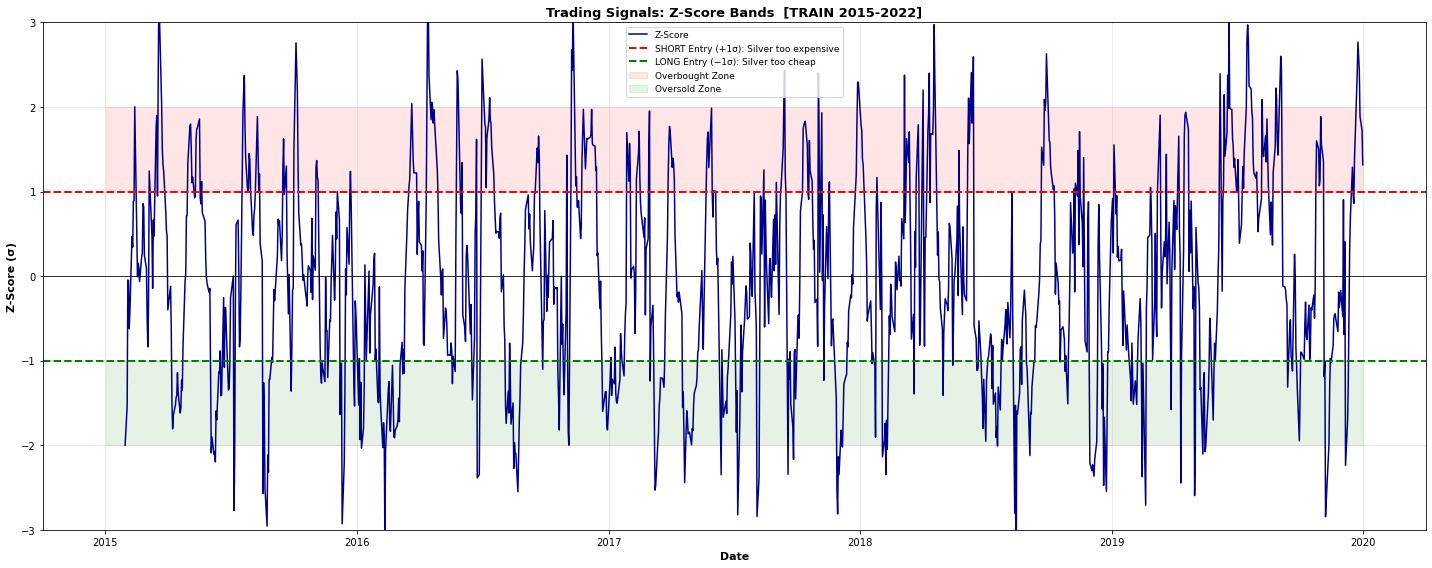

In [43]:
fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.plot(x_train, z_score_train.values, linewidth=1.5, color='darkblue', label='Z-Score')
ax1.axhline( 1.0, color='red',   linestyle='--', linewidth=2, label='SHORT Entry (+1σ): Silver too expensive')
ax1.axhline(-1.0, color='green', linestyle='--', linewidth=2, label='LONG Entry (−1σ): Silver too cheap')
ax1.axhline( 0,   color='black', linestyle='-',  linewidth=0.8)
ax1.fill_between(x_train,  1,  2, alpha=0.1, color='red',   label='Overbought Zone')
ax1.fill_between(x_train, -1, -2, alpha=0.1, color='green', label='Oversold Zone')
ax1.set_ylabel('Z-Score (σ)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Date',        fontsize=11, fontweight='bold')
ax1.set_title('Trading Signals: Z-Score Bands  [TRAIN 2015-2022]', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-3, 3)
plt.tight_layout()
plt.show()

In [44]:
@dataclass
class Trade:
    start_date  : any
    start_z     : float
    start_spread: float
    position    : str
    end_z       : float = None
    end_spread  : float = None
    end_date    : any   = None
    pnl         : float = 0.0
    profitable  : bool  = False
    holdingperiod: int  = 0

    def __str__(self):
        return (f" {self.position.upper():5} | "
                f"Entry: {self.start_date.date()} @ Spr: {self.start_spread:+.2f} |"
                f"Exit: {(self.end_date.date() if self.end_date else 'OPEN')} @ Spr: {self.end_spread:+.2f} |"
                f"Pnl: {self.pnl:.5f}")


def backtest(z_score, spread, signal, threshold=2.0, holdingperiod=30):
    trades    = []
    opentrade = []

    for t in range(len(signal) - 1):
        current_date   = signal.index[t]
        current_z      = z_score.iloc[t]
        current_spread = spread.iloc[t]
        current_signal = signal['signal'].iloc[t]

        trades_toclose = []

        for i, trade in enumerate(opentrade):
            daysheld = (current_date - trade.start_date).days
            exit_    = False

            if abs(current_z) < 0.2:
                exit_ = True
            elif trade.position == 'long'  and current_z < (trade.start_z - 1.5):
                exit_ = True
            elif trade.position == 'short' and current_z > (trade.start_z + 1.5):
                exit_ = True
            elif daysheld > holdingperiod:
                exit_ = True

            if exit_:
                trade.end_z      = current_z
                trade.end_date   = current_date
                trade.end_spread = current_spread
                trade.holdingperiod = daysheld

                if trade.position == 'long':
                    trade.pnl = current_spread - trade.start_spread
                elif trade.position == 'short':
                    trade.pnl = trade.start_spread - current_spread

                trade.profitable = trade.pnl > 0
                trades.append(trade)
                trades_toclose.append(i)

        for i in reversed(trades_toclose):
            opentrade.pop(i)

        if current_signal != 0:
            position = 'long' if current_signal == 1 else 'short'
            opentrade.append(Trade(start_date=current_date,
                                   start_spread=current_spread,
                                   start_z=current_z,
                                   position=position))
    return trades


def build_signal(z_score):
    sig = pd.DataFrame(index=z_score.index)
    sig['z_score'] = z_score
    sig['signal']  = 0
    sig.loc[z_score < -1.5, 'signal'] =  1
    sig.loc[z_score >  1.5, 'signal'] = -1
    return sig


def print_metrics(trades, label=''):
    print("=" * 70)
    print(f"PERFORMANCE METRICS  [{label}]")
    print("=" * 70)
    if not trades:
        print("  No trades generated")
        return {}
    pnls   = [t.pnl for t in trades]
    wins   = sum(1 for p in pnls if p > 0)
    gains  = sum(p for p in pnls if p > 0)
    losses = abs(sum(p for p in pnls if p < 0))
    sharpe = (np.mean(pnls) * 252**0.5) / (np.std(pnls) + 1e-9)
    print(f"\nTrade Statistics:")
    print(f"  Total Trades  : {len(trades)}")
    print(f"  Winning Trades: {wins}")
    print(f"  Losing Trades : {len(trades) - wins}")
    print(f"  Win Rate      : {wins/len(trades):.1%}")
    print(f"  Sharpe Ratio  : {sharpe:.4f}")
    print(f"\nPnL Statistics:")
    print(f"  Average PnL   : {np.mean(pnls):+.6f}")
    print(f"  Total PnL     : {np.sum(pnls):+.6f}")
    print(f"  Max PnL       : {np.max(pnls):+.6f}")
    print(f"  Min PnL       : {np.min(pnls):+.6f}")
    print(f"  Profit Factor : {gains/(losses+1e-9):.2f}")
    print(f"  Max Drawdown  : {min(np.minimum.accumulate(np.cumsum(pnls))):+.6f}")
    print("=" * 70)
    return {'win_rate': wins/len(trades), 'sharpe': sharpe,
            'total_pnl': np.sum(pnls), 'pnls': pnls,
            'profit_factor': gains/(losses+1e-9)}


# Run train backtest
signal_train = build_signal(z_score_train)
trades_train = backtest(z_score_train, spread_train, signal_train)
print(f"Running backtest on TRAIN...\n✓ Backtest complete!  Total Trades: {len(trades_train)}")
m_train = print_metrics(trades_train, 'TRAIN 2015-2022')

Running backtest on TRAIN...
✓ Backtest complete!  Total Trades: 318
PERFORMANCE METRICS  [TRAIN 2015-2022]

Trade Statistics:
  Total Trades  : 318
  Winning Trades: 224
  Losing Trades : 94
  Win Rate      : 70.4%
  Sharpe Ratio  : 2.3755

PnL Statistics:
  Average PnL   : +0.078695
  Total PnL     : +25.024998
  Max PnL       : +1.759379
  Min PnL       : -2.041870
  Profit Factor : 1.55
  Max Drawdown  : +0.479765


In [45]:
# ============================================================
# TEST PERIOD  (2023)  — warm-start Kalman from TRAIN
# ============================================================
gold_test_n   = (data_test['Gold']   - data_train['Gold'].mean())   / data_train['Gold'].std()
silver_test_n = (data_test['Silver'] - data_train['Silver'].mean()) / data_train['Silver'].std()

kf_test = KalmanFilter(gold_test_n, silver_test_n,
                        ref_gold=data_train['Gold'], ref_silver=data_train['Silver'],
                        init_beta=last_beta, init_alpha=last_alpha, init_p=last_p)
betas_test, alphas_test, last_beta_t, last_alpha_t, last_p_t = kf_test.filter()

kalman_spread_test = pd.Series(
    data_test['Silver'].values - alphas_test - betas_test * data_test['Gold'].values,
    index=data_test.index)

# Stationarity check on test Kalman spread
print("=" * 60)
print("ADF TEST ON KALMAN SPREAD  [TEST 2023]")
print("=" * 60)
res_ks_test = adfuller(kalman_spread_test.dropna(), autolag='AIC')
print(f" Test Statistics : {res_ks_test[0]:.6f}")
print(f" p-value         : {res_ks_test[1]:.6f}")
print(f" Lags used       : {res_ks_test[2]}")
print()
print(" Critical Values:")
for level, cv in res_ks_test[4].items():
    marker = '  ✓' if res_ks_test[0] < cv else '  ✗'
    print(f"   {level}: {cv:.4f}{marker}")
print()
if res_ks_test[1] < 0.10:
    print(" RESULT: Kalman spread IS STATIONARY ✓  — Mean-reverting on test period!")
else:
    print(" RESULT: Kalman spread is NOT stationary ✗ — Strategy may struggle in test period")
print("=" * 60)

spread_mean_test = kalman_spread_test.rolling(window=20).mean()
spread_std_test  = kalman_spread_test.rolling(window=20).std()
z_score_test     = (kalman_spread_test - spread_mean_test) / spread_std_test

signal_test  = build_signal(z_score_test)
trades_test  = backtest(z_score_test, kalman_spread_test, signal_test)
print(f"\n✓ Test backtest complete!  Total Trades: {len(trades_test)}")
m_test = print_metrics(trades_test, 'TEST 2023')

ADF TEST ON KALMAN SPREAD  [TEST 2023]
 Test Statistics : -2.824389
 p-value         : 0.054874
 Lags used       : 16

 Critical Values:
   1%: -3.4438  ✗
   5%: -2.8675  ✗
   10%: -2.5699  ✓

 RESULT: Kalman spread IS STATIONARY ✓  — Mean-reverting on test period!

✓ Test backtest complete!  Total Trades: 120
PERFORMANCE METRICS  [TEST 2023]

Trade Statistics:
  Total Trades  : 120
  Winning Trades: 79
  Losing Trades : 41
  Win Rate      : 65.8%
  Sharpe Ratio  : 1.5433

PnL Statistics:
  Average PnL   : +0.157126
  Total PnL     : +18.855134
  Max PnL       : +4.650885
  Min PnL       : -6.361427
  Profit Factor : 1.32
  Max Drawdown  : -3.703749


In [46]:
# ============================================================
# VALIDATE PERIOD  (2024 – Today)  — warm-start from TEST
# ============================================================
gold_val_n   = (data_val['Gold']   - data_train['Gold'].mean())   / data_train['Gold'].std()
silver_val_n = (data_val['Silver'] - data_train['Silver'].mean()) / data_train['Silver'].std()

kf_val = KalmanFilter(gold_val_n, silver_val_n,
                       ref_gold=data_train['Gold'], ref_silver=data_train['Silver'],
                       init_beta=last_beta_t, init_alpha=last_alpha_t, init_p=last_p_t)
betas_val, alphas_val, *_ = kf_val.filter()

kalman_spread_val = pd.Series(
    data_val['Silver'].values - alphas_val - betas_val * data_val['Gold'].values,
    index=data_val.index)

# Stationarity check on validate Kalman spread
print("=" * 60)
print("ADF TEST ON KALMAN SPREAD  [VALIDATE 2024-Today]")
print("=" * 60)
res_ks_val = adfuller(kalman_spread_val.dropna(), autolag='AIC')
print(f" Test Statistics : {res_ks_val[0]:.6f}")
print(f" p-value         : {res_ks_val[1]:.6f}")
print(f" Lags used       : {res_ks_val[2]}")
print()
print(" Critical Values:")
for level, cv in res_ks_val[4].items():
    marker = '  ✓' if res_ks_val[0] < cv else '  ✗'
    print(f"   {level}: {cv:.4f}{marker}")
print()
if res_ks_val[1] < 0.10:
    print(" RESULT: Kalman spread IS STATIONARY ✓  — Strategy valid on live-like data!")
else:
    print(" RESULT: Kalman spread is NOT stationary ✗ — Do NOT trade live without further review")
print("=" * 60)

spread_mean_val = kalman_spread_val.rolling(window=20).mean()
spread_std_val  = kalman_spread_val.rolling(window=20).std()
z_score_val     = (kalman_spread_val - spread_mean_val) / spread_std_val

signal_val   = build_signal(z_score_val)
trades_val   = backtest(z_score_val, kalman_spread_val, signal_val)
print(f"\n✓ Validate backtest complete!  Total Trades: {len(trades_val)}")
m_val = print_metrics(trades_val, 'VALIDATE 2024-Today')

ADF TEST ON KALMAN SPREAD  [VALIDATE 2024-Today]
 Test Statistics : -5.504877
 p-value         : 0.000002
 Lags used       : 21

 Critical Values:
   1%: -3.4368  ✓
   5%: -2.8644  ✓
   10%: -2.5683  ✓

 RESULT: Kalman spread IS STATIONARY ✓  — Strategy valid on live-like data!

✓ Validate backtest complete!  Total Trades: 253
PERFORMANCE METRICS  [VALIDATE 2024-Today]

Trade Statistics:
  Total Trades  : 253
  Winning Trades: 198
  Losing Trades : 55
  Win Rate      : 78.3%
  Sharpe Ratio  : 3.5718

PnL Statistics:
  Average PnL   : +0.788341
  Total PnL     : +199.450187
  Max PnL       : +29.074261
  Min PnL       : -8.010040
  Profit Factor : 3.62
  Max Drawdown  : -0.304814


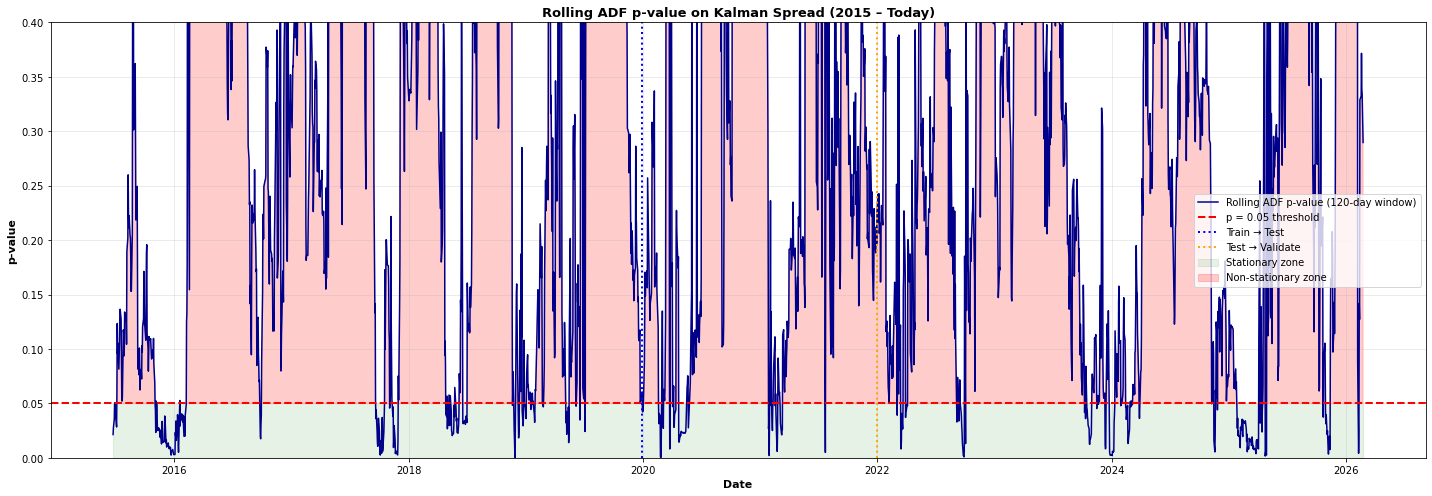

Rolling stationarity: 23.3% of windows had p < 0.10
(Higher = more consistently mean-reverting across time)


In [47]:
# ============================================================
# ROLLING ADF p-value ON KALMAN SPREAD  (full period)
# ============================================================
import warnings
warnings.filterwarnings('ignore')

# Build full-period Kalman spread using train normalization
gold_full_n   = (data['Gold']   - data_train['Gold'].mean())   / data_train['Gold'].std()
silver_full_n = (data['Silver'] - data_train['Silver'].mean()) / data_train['Silver'].std()

kf_full = KalmanFilter(gold_full_n, silver_full_n,
                        ref_gold=data_train['Gold'], ref_silver=data_train['Silver'])
betas_full, alphas_full, *_ = kf_full.filter()

kalman_spread_full = pd.Series(
    data['Silver'].values - alphas_full - betas_full * data['Gold'].values,
    index=data.index)

window = 120
rolling_pvals = []
rolling_dates = []

for i in range(window, len(kalman_spread_full)):
    sub = kalman_spread_full.iloc[i - window:i].dropna()
    try:
        p_ = adfuller(sub, autolag='AIC')[1]
    except:
        p_ = np.nan
    rolling_pvals.append(p_)
    rolling_dates.append(kalman_spread_full.index[i])

rolling_pvals = pd.Series(rolling_pvals, index=rolling_dates)

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(rolling_pvals.index, rolling_pvals.values, color='darkblue', linewidth=1.5,
        label='Rolling ADF p-value (120-day window)')
ax.axhline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05 threshold')
ax.fill_between(rolling_pvals.index, 0, 0.05, alpha=0.1, color='green', label='Stationary zone')
ax.fill_between(rolling_pvals.index, 0.05, rolling_pvals.values,
                where=(rolling_pvals.values > 0.05), alpha=0.2, color='red', label='Non-stationary zone')

ax.axvline(pd.Timestamp(train_end), color='blue',   linestyle=':', linewidth=2, label='Train → Test')
ax.axvline(pd.Timestamp(test_end),  color='orange', linestyle=':', linewidth=2, label='Test → Validate')

ax.set_title('Rolling ADF p-value on Kalman Spread (2015 – Today)', fontsize=13, fontweight='bold')
ax.set_ylabel('p-value', fontsize=11, fontweight='bold')
ax.set_xlabel('Date',    fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 0.4)
plt.tight_layout()
plt.show()

pct = (rolling_pvals < 0.10).mean()
print(f"Rolling stationarity: {pct:.1%} of windows had p < 0.10")
print("(Higher = more consistently mean-reverting across time)")

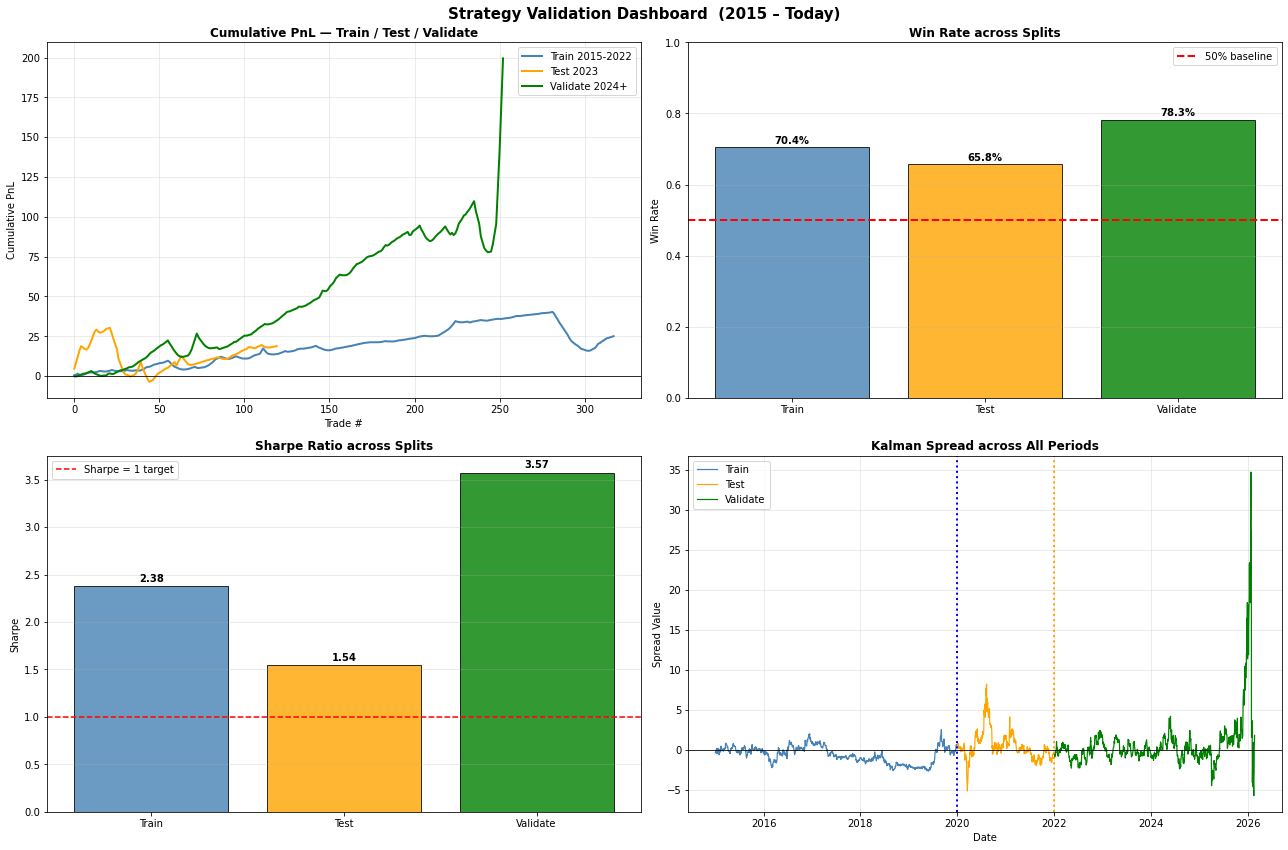

In [50]:
# ============================================================
# VALIDATION DASHBOARD
# ============================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Cumulative PnL per split
for pnls_, label_, color_ in [
    (m_train.get('pnls', []), 'Train 2015-2022', 'steelblue'),
    (m_test.get('pnls',  []), 'Test 2023',       'orange'),
    (m_val.get('pnls',   []), 'Validate 2024+',  'green'),
]:
    if pnls_:
        ax1.plot(np.cumsum(pnls_), label=label_, linewidth=2, color=color_)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_title('Cumulative PnL — Train / Test / Validate', fontweight='bold')
ax1.set_xlabel('Trade #')
ax1.set_ylabel('Cumulative PnL')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Win rate comparison
labels_ = ['Train', 'Test', 'Validate']
wrs_    = [m_train.get('win_rate', 0), m_test.get('win_rate', 0), m_val.get('win_rate', 0)]
colors_ = ['steelblue', 'orange', 'green']
bars    = ax2.bar(labels_, wrs_, color=colors_, edgecolor='black', alpha=0.8)
ax2.axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% baseline')
for bar, wr in zip(bars, wrs_):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{wr:.1%}', ha='center', fontweight='bold')
ax2.set_title('Win Rate across Splits', fontweight='bold')
ax2.set_ylabel('Win Rate')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Sharpe ratio comparison
sharpes_ = [m_train.get('sharpe', 0), m_test.get('sharpe', 0), m_val.get('sharpe', 0)]
bars     = ax3.bar(labels_, sharpes_, color=colors_, edgecolor='black', alpha=0.8)
ax3.axhline(0, color='black', linewidth=0.8)
ax3.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Sharpe = 1 target')
for bar, s in zip(bars, sharpes_):
    ax3.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + (0.05 if s >= 0 else -0.15),
             f'{s:.2f}', ha='center', fontweight='bold')
ax3.set_title('Sharpe Ratio across Splits', fontweight='bold')
ax3.set_ylabel('Sharpe')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Spread across all periods
ax4.plot(data_train.index, kalman_spread_train.values, color='steelblue', linewidth=1.2, label='Train')
ax4.plot(data_test.index,  kalman_spread_test.values,  color='orange',    linewidth=1.2, label='Test')
ax4.plot(data_val.index,   kalman_spread_val.values,   color='green',     linewidth=1.2, label='Validate')
ax4.axhline(0, color='black', linewidth=0.8)
ax4.axvline(pd.Timestamp(train_end), color='blue',   linestyle=':', linewidth=2)
ax4.axvline(pd.Timestamp(test_end),  color='orange', linestyle=':', linewidth=2)
ax4.set_title('Kalman Spread across All Periods', fontweight='bold')
ax4.set_ylabel('Spread Value')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Strategy Validation Dashboard  (2015 – Today)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()